<ipython-input-1-3341029417>:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


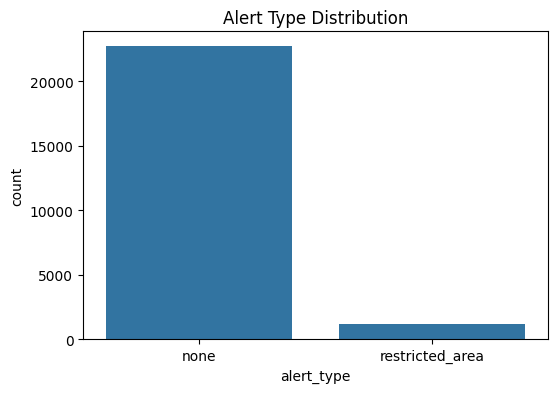

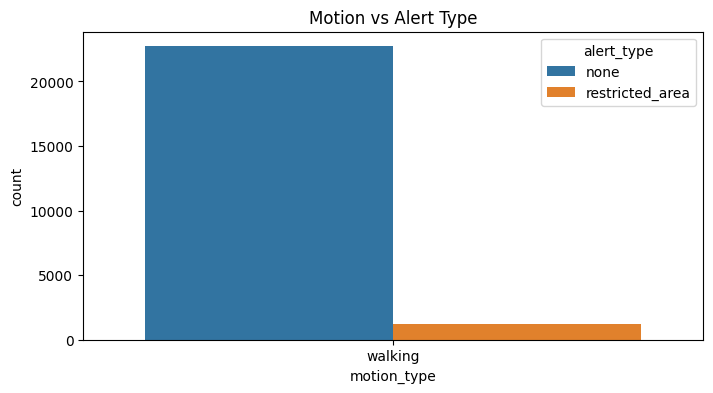

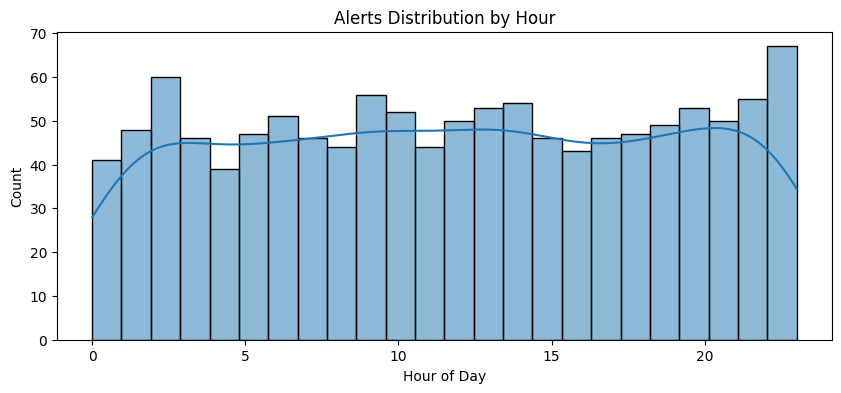


Classification Report:
                 precision    recall  f1-score   support

           none       0.95      1.00      0.97      4547
restricted_area       0.00      0.00      0.00       237

       accuracy                           0.95      4784
      macro avg       0.48      0.50      0.49      4784
   weighted avg       0.90      0.95      0.93      4784



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model Accuracy: 0.95


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Load dataset
df = pd.read_excel("/content/drive/MyDrive/Amrita Immersion program/Mining_Dataset_Synthetic (1).xlsx")

# 1. Data Cleaning
# Keep only relevant posture and motion types
valid_postures = ['standing', 'sitting', 'falling', 'lying']
valid_motions = ['walking', 'running', 'still']

df = df[df['posture_status'].isin(valid_postures)]
df = df[df['motion_type'].isin(valid_motions)]

# Handle missing values
df.fillna(method='ffill', inplace=True)

# 2. Label Encoding
le_posture = LabelEncoder()
le_motion = LabelEncoder()
le_zone = LabelEncoder()
le_alert = LabelEncoder()

df['posture_encoded'] = le_posture.fit_transform(df['posture_status'])
df['motion_encoded'] = le_motion.fit_transform(df['motion_type'])
df['zone_encoded'] = le_zone.fit_transform(df['zone_id'])
df['alert_type'] = df['alert_type'].fillna('none')  # Ensure no NaNs
df['alert_encoded'] = le_alert.fit_transform(df['alert_type'])

# 3. Time Features
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['day_part'] = df['hour'].apply(lambda x: 0 if 6 <= x < 12 else 1 if 12 <= x < 18 else 2)

# 4. Exploratory Data Analysis (EDA)
# Alert Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='alert_type', data=df)
plt.title("Alert Type Distribution")
plt.show()

# Posture vs Alert
plt.figure(figsize=(8,4))
sns.countplot(x='posture_status', hue='alert_type', data=df)
plt.title("Posture vs Alert Type")
plt.show()

# Motion Type vs Alert
plt.figure(figsize=(8,4))
sns.countplot(x='motion_type', hue='alert_type', data=df)
plt.title("Motion vs Alert Type")
plt.show()

# Hourly Alert Trends
plt.figure(figsize=(10,4))
sns.histplot(df[df['alert_type'] != 'none']['hour'], bins=24, kde=True)
plt.title("Alerts Distribution by Hour")
plt.xlabel("Hour of Day")
plt.show()

# 5. Model Training

# Features and Target
features = ['posture_encoded', 'motion_encoded', 'zone_encoded', 'hour', 'day_part']
X = df[features]
y = df['alert_encoded']

# Train/Test Split (with stratification)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train Random Forest
model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Classification Report
labels = list(np.unique(y_test))  # Ensure only classes present in test set
target_names = le_alert.inverse_transform(labels)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, labels=labels, target_names=target_names))

# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred, labels=labels)
plt.figure(figsize=(6,4))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Accuracy
accuracy = model.score(X_test, y_test)
print(f"Model Accuracy: {accuracy:.2f}")